In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.stats import linregress


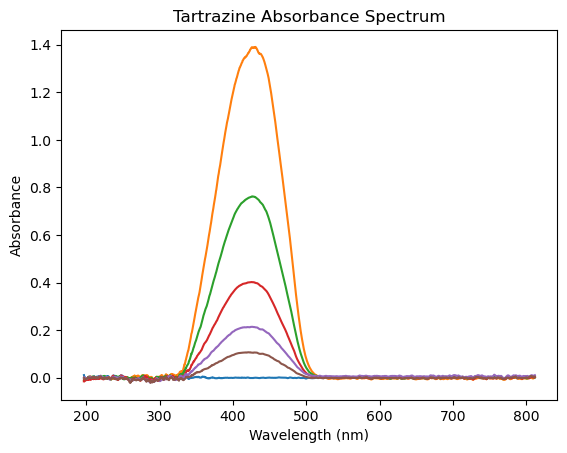

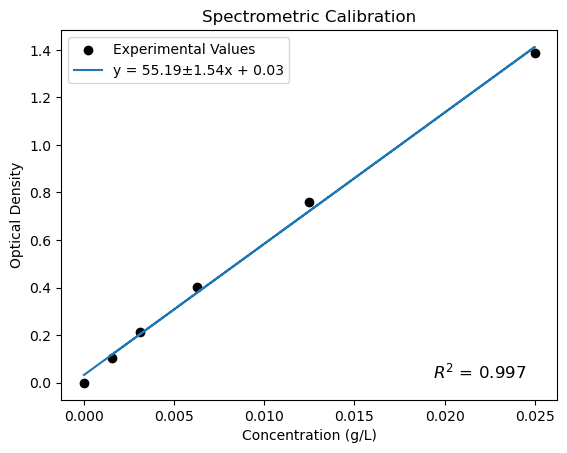

In [9]:
Conc_inf=0.5 #g/L
MW_tart=534 #g/mol

x=np.linspace(0,60,100)
yrange1=np.ones(100) * 0.012
yrange2=np.ones(100) * 0.008

calib=[0, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
calib_sheets=["DI Water", "1", "2", "3", "4", "5"]
wavelength_find=427 #nm
def find_abs(filename, sheet_name):
    rawfile = pd.read_excel(filename, sheet_name)
    rawdata = np.array(rawfile)
    wavelength = rawdata[:,0]
    absorbance = rawdata[:,1]
    idx = np.round(wavelength) == wavelength_find
    return absorbance[idx].mean()
def plot_abs(filename, sheet_name):
    rawfile = pd.read_excel(filename, sheet_name)
    rawdata = np.array(rawfile)
    wavelength = rawdata[:,0]
    absorbance = rawdata[:,1]
    plt.plot(wavelength, absorbance)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absorbance")
    plt.title("Tartrazine Absorbance Spectrum")

absorb_cal=[]
for i in calib_sheets:
    absorb_cal.append(find_abs('Lab 3 (1).xlsx',i))
    plot_abs('Lab 3 (1).xlsx',i)

calib_line=linregress(calib,absorb_cal)
slope_calib=calib_line.slope
std_error_calib=calib_line.stderr
intercept_calib=calib_line.intercept
r_sqrd=(calib_line.rvalue)**2
plt.figure(0)
plt.scatter(calib, absorb_cal, color='black', label = "Experimental Values")
plt.plot(calib, np.array(calib)*slope_calib+intercept_calib, label = f"y = {slope_calib:.02f}±{std_error_calib:.02f}x + {intercept_calib:.02f}")
plt.text(0.75, 0.05, f'$R^2$ = {r_sqrd:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')
plt.xlabel("Concentration (g/L)")
plt.ylabel("Optical Density")
plt.legend()
plt.title("Spectrometric Calibration")
plt.show()



In [10]:
def conc_find(filename, sheet_name, volume):
    absorb_avg=find_abs(filename, sheet_name)
    concentration = (absorb_avg-0.03) / 55.19
    concentration = concentration*1000/MW_tart
    return concentration

#Molar Concentration Plot
def plot_conc(time, conc, diam, t):
    plt.scatter(time, conc, color='black')
    plt.xlabel("Time (min)")
    plt.ylabel("Concentration (mol/L)")
    plt.title("Variations in Concentration\nBead Diameter of " + str(diam) +"m" + " and Residence Time of " +str(t) +"s")
    plt.show()

#Mass Frac Release Plot
def mass_frac(time, conc, vol,k):
    Mt_array=np.array(conc)*0.1
    M_inf=Conc_inf*vol
    Mt_Minf=np.array(Mt_array)/(M_inf)
    return Mt_Minf
    
def plot_mass_frac(time, Mt_Minf, diam, t):
    plt.scatter(time, Mt_Minf, color='black')
    plt.xlabel("Time (min)")
    plt.ylabel("Mt/M∞")
    plt.title("Analysis of F\nBead Diameter of " + str(diam) +"m" + " and Residence Time of " +str(t)+"s")
    plt.show()
    
def plot_logmass_frac(time, Mt_Minf,k, diam, t):
    line=scipy.stats.linregress(np.log10(time)+np.log10(k),np.log10(Mt_Minf))
    n = line.slope
    n_error=line.stderr
    r_value=(line.rvalue)**2
    plt.scatter(np.log10(time)+np.log10(k), np.log10(Mt_Minf), color='black', label=f"Experimental Values")
    plt.plot(np.log10(time)+np.log10(k), n*(np.log10(time)+np.log10(k))+line.intercept, label=f"y = {n:.02f}±{n_error:.02f}x + {line.intercept:.02f}")
    plt.xlabel("log(time)")
    plt.ylabel("log(F)")
    plt.text(0.75, 0.05, f'$R^2$ = {r_sqrd:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')
    plt.title("Mass Fraction Released\nBead Diameter of " + str(diam) +"m" + " and Residence Time of " +str(t)+"s")
    plt.legend()
    plt.show()
    return n
def k_error(r, error_r,t):
    # Constants
    D = 4.9e-10
    C = 6 * ((D * t) / np.pi) ** 0.5
    dk_dr = -C / r**2
    error_k = abs(dk_dr) * error_r
    return error_k

Maximum Concentration: 0.00235


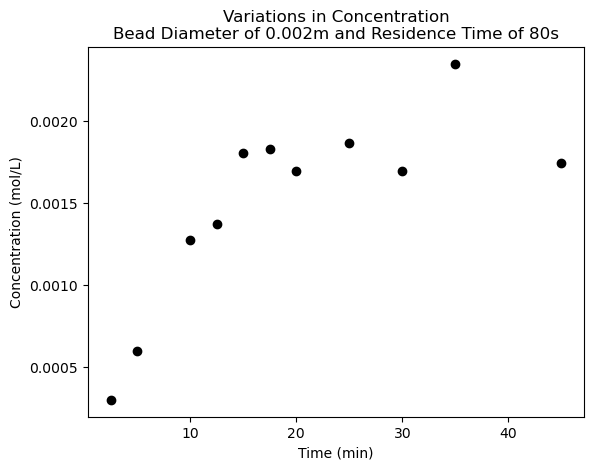

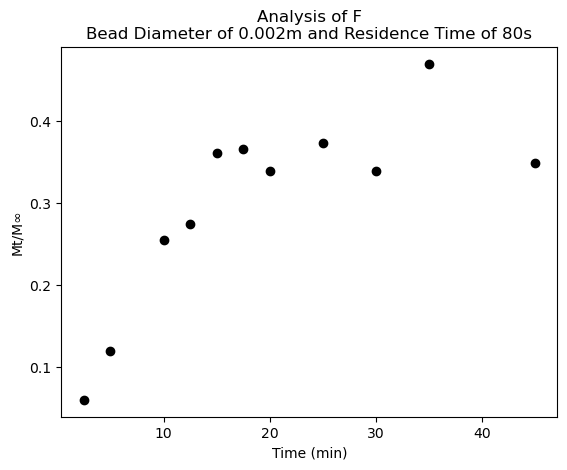

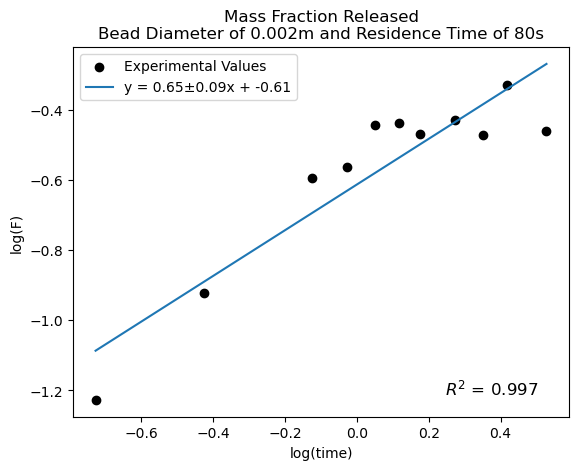

Final Release Rate Prediction: 0.012
k value for Gauge 25: 0.07±0.00007


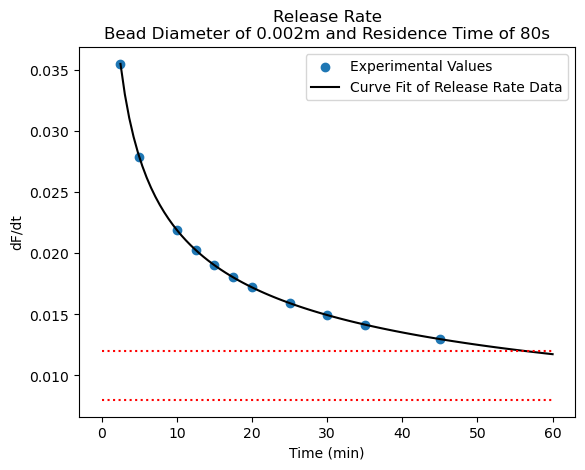

In [11]:
sheet_name25 = ["230", "500", "1000", "1230", "1500", "1730", "2000", "2500", "3000", "3500", "4500"]

d25=0.002
r25=0.002/2 #m

k25=6*(((4.9e-10)/(np.pi*r25**2))**0.5)
volume25=0.001 #L

time25=np.array([2.5, 5, 10, 12.5, 15, 17.5, 20, 25, 30, 35, 45])
conc25=[]

for i in sheet_name25:
    conc25.append(conc_find('Gauge 25, 0.2cm.xlsx',i, volume25))
print(f"Maximum Concentration: {np.max(conc25):0.5f}")

plot_conc(time25,conc25,d25, 80)
Mt_Minf25=mass_frac(time25, conc25, volume25, k25)
plot_mass_frac(time25, Mt_Minf25, d25, 80)
n25=plot_logmass_frac(time25, Mt_Minf25, k25,d25, 80)

def dfdt(time, k, n):
    return k*n*time**(n-1)

df_dt25=dfdt(time25, k25, n25)

popt25, pcov25 = curve_fit(dfdt, time25,df_dt25)

release_rate_pred25 = dfdt(60, popt25[0], popt25[1])
error25 = np.sqrt(np.diag(pcov25))
error25k= k_error(r25,1e-6,1)
plt.scatter(time25, df_dt25, label="Experimental Values")
time_fit25=np.linspace(min(time25), 60, 100)
plt.plot(time_fit25, dfdt(time_fit25, *popt25), label="Curve Fit of Release Rate Data", color='black')
plt.plot(x, yrange1, linestyle=':', color='red')
plt.plot(x, yrange2, linestyle=':', color='red')
plt.xlabel("Time (min)")
plt.ylabel("dF/dt")
plt.title("Release Rate\nBead Diameter of " + str(d25) +"m" + " and Residence Time of 80s")
plt.legend()
print(f"Final Release Rate Prediction: {release_rate_pred25:.3f}")
print(f"k value for Gauge 25: {k25:.2f}±{error25k:.5f}")

Maximum Concentration: 0.00815


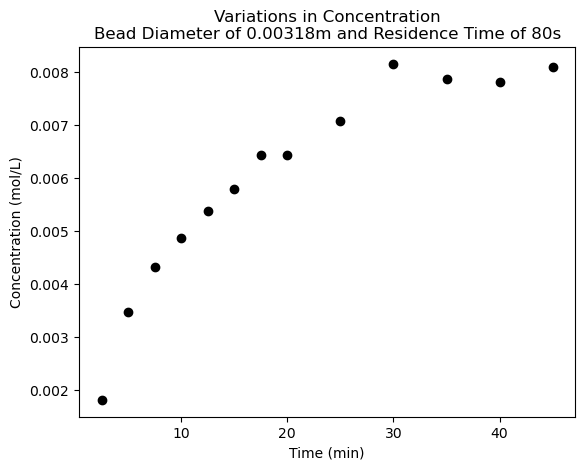

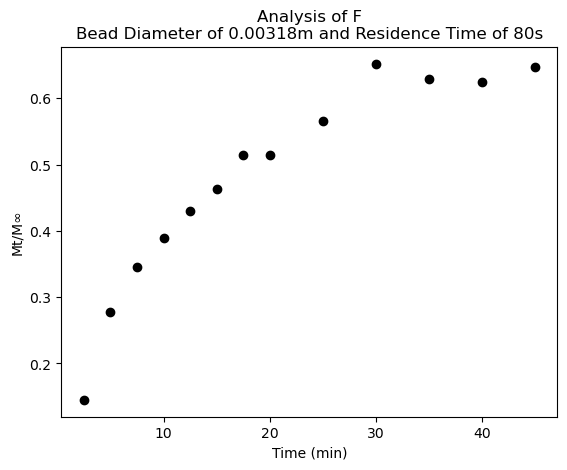

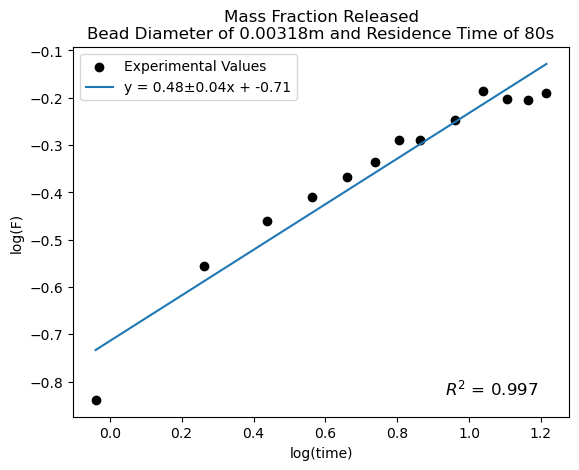

Final Release Rate Prediction: 0.021
n value for Gauge 14, Residence Time 80s: 0.482
k value for Gauge 14, Residence Time 80s: 0.37±0.00023


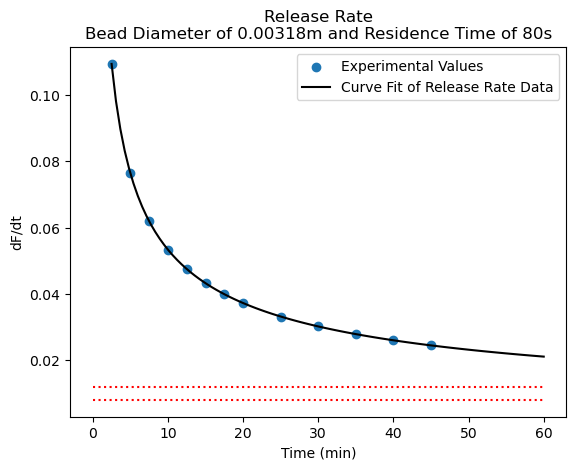

In [12]:


sheet_name14 = ["230", "500", "730", "1000", "1230", "1500", "1730", "2000", "2500", "3000", "3500", "4000", "4500"]

d14=0.00318
r14=0.00318/2 #m

k14=6*(((4.9e-10)/(np.pi*r14**2))**0.5)
volume14=0.0025 #L

time14=np.array([2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 25, 30, 35, 40, 45])
conc14=[]

for i in sheet_name14:
    conc14.append(conc_find('Gauge 14.xlsx',i, volume14))
print(f"Maximum Concentration: {np.max(conc14):0.5f}")

plot_conc(time14,conc14,d14, 80)
Mt_Minf14=mass_frac(time14, conc14, volume14, k14)
plot_mass_frac(time14, Mt_Minf14, d14, 80)
n14=plot_logmass_frac(time14, Mt_Minf14, k14,d14, 80)

def dfdt(time, k, n):
    return k*n*time**(n-1)

df_dt14=dfdt(time14, k14, n14)

popt14, pcov14 = curve_fit(dfdt, time14,df_dt14)

release_rate_pred14 = dfdt(60, popt14[0], popt14[1])
error14 = np.sqrt(np.diag(pcov14))
error14k= k_error(r14,1e-6,60)
plt.scatter(time14, df_dt14, label="Experimental Values")
time_fit=np.linspace(min(time14), 60, 100)
plt.plot(time_fit, dfdt(time_fit, *popt14), label="Curve Fit of Release Rate Data", color='black')
plt.plot(x, yrange1, linestyle=':', color='red')
plt.plot(x, yrange2, linestyle=':', color='red')
plt.xlabel("Time (min)")
plt.ylabel("dF/dt")
plt.title("Release Rate\nBead Diameter of " + str(d14) +"m" + " and Residence Time of 80s")
plt.legend()
print(f"Final Release Rate Prediction: {release_rate_pred14:.3f}")
print(f"n value for Gauge 14, Residence Time 80s: {n14:.3f}")
print(f"k value for Gauge 14, Residence Time 80s: {k14:.2f}±{error14k:.5f}")


Maximum Concentration: 0.00280


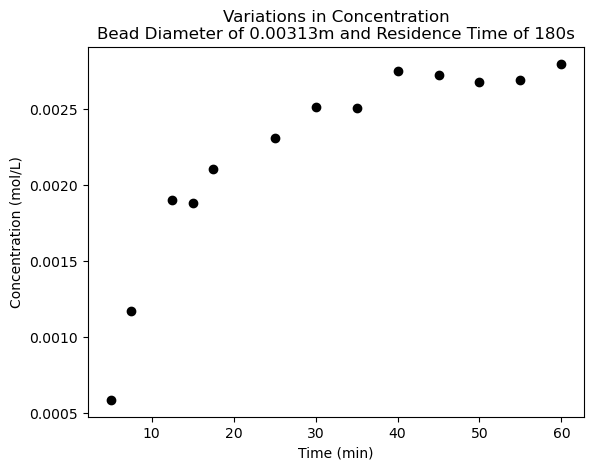

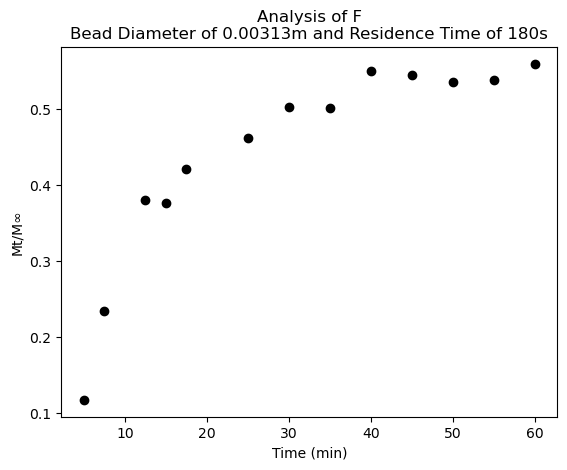

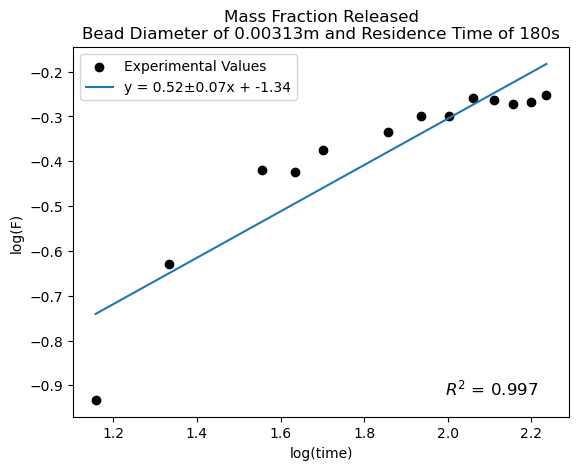

Final release rate = 0.0034
Mean release rate = 0.0057
k value for Gauge 14, Residence Time of 180s: 0.0479±0.00024


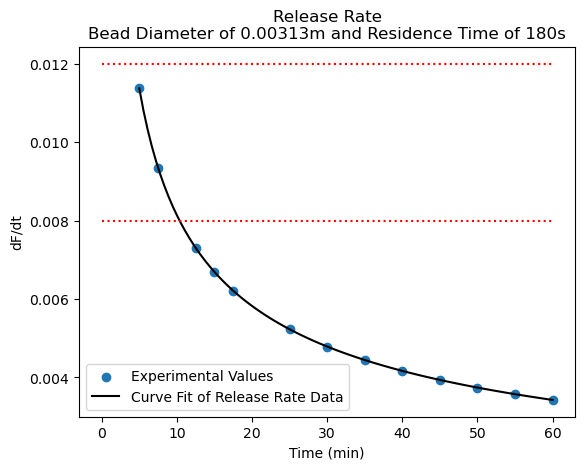

In [13]:
sheet_name14f = [ "500", "730", "1230", "1500", "1730", "2500", "3000", "3500", "4000", "4500","5000", "5500", "6000"]
d14f=0.00313
r14f=0.00313/2 #m
k14f=6*(((4.9e-10)/(np.pi*r14f**2))**0.5)
volume14f=0.001 #L

time14f=np.array([ 5, 7.5, 12.5, 15, 17.5, 25, 30, 35, 40, 45, 50, 55, 60])
conc14f=[]

for i in sheet_name14f:
    conc14f.append(conc_find('Gauge 14 Test 2.xlsx',i, volume14f))
print(f"Maximum Concentration: {np.max(conc14f):0.5f}")

plot_conc(time14f,conc14f,d14f, 180)
Mt_Minf14f=mass_frac(time14f, conc14f, volume14f, k14f)
plot_mass_frac(time14f, Mt_Minf14f, d14f, 180)
n14f=plot_logmass_frac(time14f*60, Mt_Minf14f, k14f,d14f, 180)

def dfdt(time, k, n):
    return k*n*time**(n-1)

df_dt14f=dfdt(time14f, k14f, n14f)

popt14f, pcov14f = curve_fit(dfdt, time14f,df_dt14f)

release_rate_pred14f = dfdt(60, popt14f[0], popt14f[1])
error14f = np.sqrt(np.diag(pcov14f))
error14kf= k_error(r14f,1e-6,60)
plt.scatter(time14f, df_dt14f, label="Experimental Values")
time_fit14f=np.linspace(min(time14f), 60, 100)
plt.plot(time_fit14f, dfdt(time_fit14f, *popt14f), label="Curve Fit of Release Rate Data", color='black')
plt.plot(x, yrange1, linestyle=':', color='red')
plt.plot(x, yrange2, linestyle=':', color='red')
plt.xlabel("Time (min)")
plt.ylabel("dF/dt")
plt.title("Release Rate\nBead Diameter of " + str(d14f) +"m" + " and Residence Time of 180s")
plt.legend()
print(f"Final release rate = {df_dt14f[-1]:.4f}")
print(f"Mean release rate = {np.mean(df_dt14f):.4f}")
print(f"k value for Gauge 14, Residence Time of 180s: {k14f:.4f}±{error14kf:.5f}")

Maximum Concentration: 0.00399


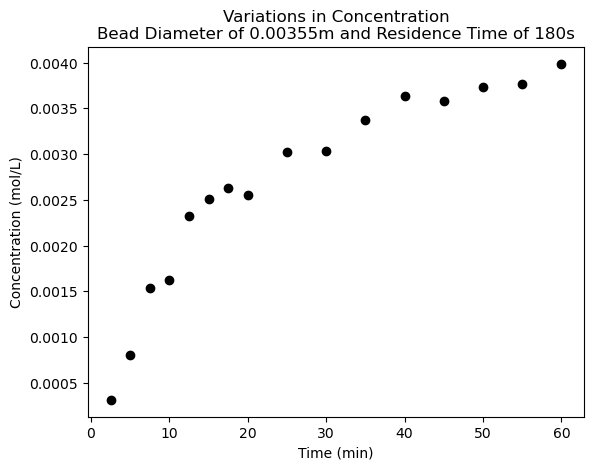

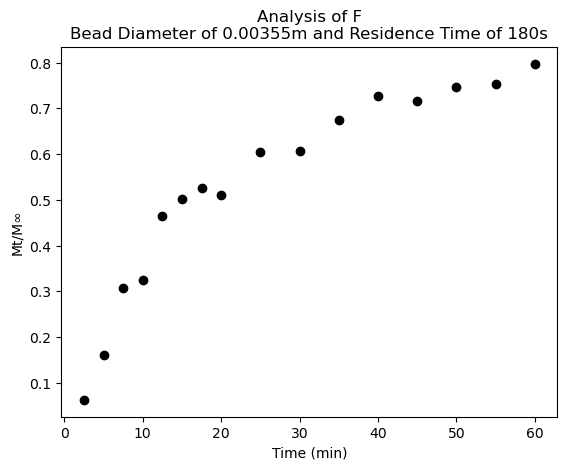

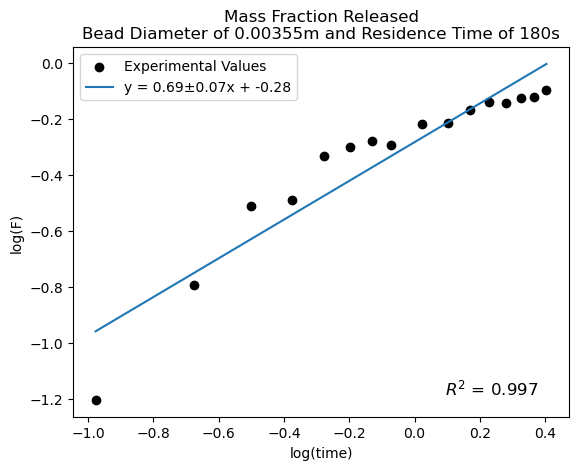

Final release rate = 0.0082
n value for Gauge 13: 0.69
k value for Gauge 13: 0.04±0.00018


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


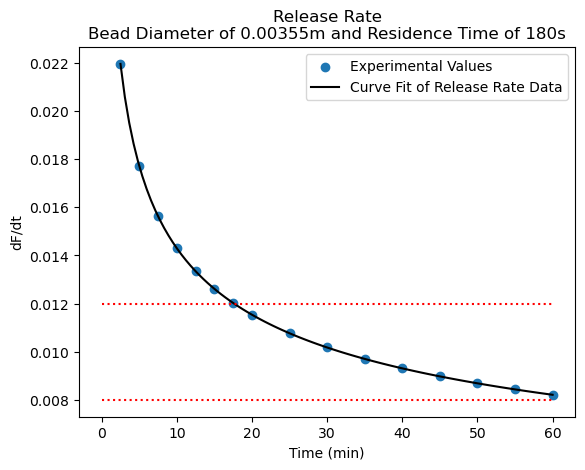

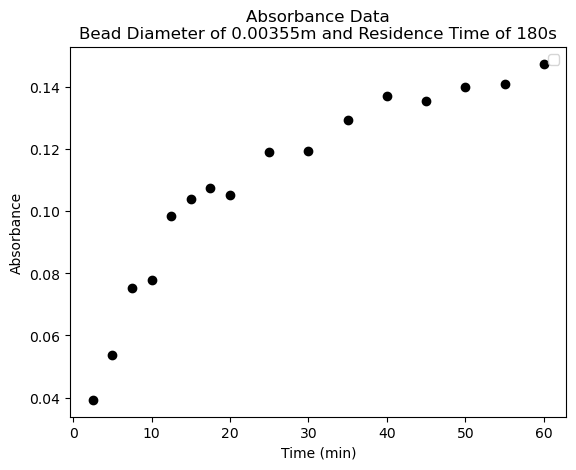

In [15]:
sheet_name13 = ["230", "500", "730", "1000", "1230", "1500", "1730", "2000", "2500", "3000", "3500", "4000", "4500","5000", "5500", "6000"]
d13=0.00355
r13=0.00355/2 #m
k13=6*(((4.9e-10)/(np.pi*r13**2))**0.5)
volume13=0.001 #L

time13=np.array([2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 25, 30, 35, 40, 45, 50, 55, 60])
conc13=[]
abs13=[]

for i in sheet_name13:
    conc13.append(conc_find('Gauge 13 test 2.xlsx',i, volume13))
print(f"Maximum Concentration: {np.max(conc13):0.5f}")

plot_conc(time13,conc13,d13, 180)
Mt_Minf13=mass_frac(time13, conc13, volume13, k13)
plot_mass_frac(time13, Mt_Minf13, d13, 180)
n13=plot_logmass_frac(time13, Mt_Minf13, k13,d13, 180)

def dfdt(time, k, n):
    return k*n*time**(n-1)

df_dt13=dfdt(time13, k13, n13)

popt13, pcov13 = curve_fit(dfdt, time13,df_dt13)

release_rate_pred13 = dfdt(60, popt13[0], popt13[1])
error13 = np.sqrt(np.diag(pcov13))
error13k= k_error(r13,1e-6,60)
plt.scatter(time13, df_dt13, label="Experimental Values")
time_fit13=np.linspace(min(time13), 60, 100)
plt.plot(time_fit13, dfdt(time_fit13, *popt13), label="Curve Fit of Release Rate Data", color='black')
plt.plot(x, yrange1, linestyle=':', color='red')
plt.plot(x, yrange2, linestyle=':', color='red')
plt.xlabel("Time (min)")
plt.ylabel("dF/dt")
plt.title("Release Rate\nBead Diameter of " + str(d13) +"m" + " and Residence Time of 180s")
plt.legend()
print(f"Final release rate = {df_dt13[-1]:.4f}")
print(f"n value for Gauge 13: {n13:.2f}")
print(f"k value for Gauge 13: {k13:.2f}±{error13k:.5f}")

for s in sheet_name13:
    abs13.append(find_abs('Gauge 13 test 2.xlsx', s))
plt.figure(5)
plt.scatter(time13, abs13, color='black')
plt.xlabel("Time (min)")
plt.ylabel("Absorbance")
plt.title("Absorbance Data\nBead Diameter of " + str(d13) +"m" + " and Residence Time of 180s")
plt.legend()
plt.show()